# 4- Feature Enrichment 

There are 3 ways to enrich the data:
1. Feature Extraction: obtaining new features from existing features.
2. Feature Engineering: transformation of raw data into features suitable for modeling.
3. Feature Transformation: transformation of data to improve the accuracy of the algorithm.

In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
df = pd.read_csv("flat_file_after_data_cleansing.csv")


C:\Users\itzikjan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Expanding the output display to see more rows and columns:
pd.set_option('display.max_rows', 200 , 'display.max_columns', 200)

In [4]:
df.head(3)

,Unnamed: 0,listing_id,name,target_start_date_period,target_end_date_period,target_avg_dollar_price_in_period,start_date_previous_period,end_date_previous_period,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,last_review,listing_url,scrape_id,last_scraped,summary,space,description,experiences_offered,notes,transit,access,interaction,house_rules,neighborhood_overview,host_about,host_since,picture_url,host_url,host_location,host_response_time,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,smart_location,market,country_code,country,is_location_exact,property_type,bed_type,amenities,square_feet,weekly_price,monthly_price,calendar_updated,first_review,calendar_last_scraped,license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,cancellation_policy,concat_comments,concat_comments_sentiment,target_num_of_day_in_period,target_num_of_booked_days,booked_up_target,num_of_day_in_previous_period,num_of_booked_days_in_previous_period,occupancy_last_period,avg_dollar_price_in_previous_period,price,minimum_nights,number_of_reviews,DaysPassed_last_review,reviews_per_month,calculated_host_listings_count,availability_365,DaysPassed_host_since,host_response_rate,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,DaysPassed_first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,size,concat_comments_polarity,concat_comments_subjectivity,sqrt_calculated_host_listings_count,sigmoid_calculated_host_listings_count,sqrt_bedrooms,sqrt_guests_included,host_response_rate_cat,size_cat,avg_dollar_price_in_previous_period_cat,concat_comments_subjectivity_cat,concat_comments_polarity_cat,review_scores_value_cat,review_scores_checkin_cat,review_scores_location_cat,review_scores_communication_cat,review_scores_accuracy_cat,review_scores_cleanliness_cat,review_scores_rating_cat,reviews_per_month_cat,DaysPassed_first_review_cat,DaysPassed_last_review_cat,beds_cat,bathrooms_cat,DaysPassed_host_since_cat,host_total_listings_count_cat,bedrooms_cat,sqrt_bedrooms_cat
0,0,7071,BrightRoom with sunny greenview!,2019-06-01,2019-08-31,NaN,2018-11-07,2019-05-31,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,2018-11-04,https://www.airbnb.com/rooms/7071,2.018111e+13,2018-11-07,Cozy and large room in the beautiful district ...,"The BrightRoom is an approx. 20 sqm (215ft��),...",Cozy and large room in the beautiful district ...,none,I hope you enjoy your stay to the fullest! Ple...,Best access to other parts of the city via pub...,"The guests have access to the bathroom, a smal...",I am glad if I can give you advice or help as ...,Please take good care of everything during you...,"Great neighborhood with plenty of Caf��s, Bake...","I'm a creative person, adventurer, and travele...",2009-05-16,https://a0.muscache.com/im/pictures/21278/32a1...,https://www.airbnb.com/users/show/17391,"Berlin, Berlin, Germany",within an hour,t,https://a0.muscache.com/im/pictures/user/48c3d...,https://a0.muscache.com/im/pictures/user/48c3d...,Prenzlauer Berg,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",Helmholtzplatz,Pankow,Berlin,Berlin,10437.0,"Berlin, Germany",Berlin,DE,Germany,t,Apartment,Real Bed,"{Wifi,Heating,""Family/kid friendly"",Essentials...",NaN,NaN,NaN,3 days ago,2009-08-18,2018-11-07,NaN,f,f,f,f,moderate,##������ ������������ ������������ �����������...,positive_sentiment,92,92,1,206,180,0.87,44.3846,42.0,2.0,197.0,1042.0,1.75,1.0,26.0,4501.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,24.0,10.0,15.0,26.0,26.0,4407.0,96.0,10.0,10.0,1

In [5]:
def drop_additional_index_columns(_df):
    # dropping additional index columns that start with "Unnamed" - dropping these columns
    columns_to_drop = [x for x in _df.columns.to_list() if x.startswith("Unnamed")]
    print("dropping coulmns: ", columns_to_drop) # [Unamed..., Unamed..]
    return _df.drop(columns=columns_to_drop, axis=1, inplace=False)

df = drop_additional_index_columns(df)

dropping coulmns:  ['Unnamed: 0']


In [6]:
# Representing the dimensionality of the DataFrame (before adding new variables):
df.shape

(157864, 134)

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157864 entries, 0 to 157863
Data columns (total 134 columns):
 #    Column                                   Non-Null Count   Dtype  
---   ------                                   --------------   -----  
 0    listing_id                               157864 non-null  int64  
 1    name                                     157451 non-null  object 
 2    target_start_date_period                 157864 non-null  object 
 3    target_end_date_period                   157864 non-null  object 
 4    target_avg_dollar_price_in_period        43919 non-null   float64
 5    start_date_previous_period               157864 non-null  object 
 6    end_date_previous_period                 157864 non-null  object 
 7    host_id                                  157864 non-null  int64  
 8    host_name                                157682 non-null  object 
 9    neighbourhood_group                      157864 non-null  object 
 10   neighbourhood     

## Feature Extraction

The addtional variables that were created in "Addition to Flat file" notebook are:
1. size - extract it from the "description" column.
2. concat_comments_polarity (Sentiment Analysis) - extract from "concat_comments" column
3. concat_comments_subjectivity (Sentiment Analysis) - extract from "concat_comments" column
4. concat_comments_sentiment  (Sentiment Analysis) - extract from "concat_comments" column

This variables were created in the Addition to Flat file notebook because these include NA and need to be handled in the EDA and in the Data Cleansing section. 


## Feature Engineering

Feature Engineering is based on the patterns from EDA section.

### Variable modification

I have already performed transformation in the Data cleansing section (fixing outliers).


The following variables have been transfomed (because could not replaced with None): 
1. 'target_avg_dollar_price_in_period' --> 'log_target_avg_dollar_price_in_period'
2. 'calculated_host_listings_count' --> 'sqrt_calculated_host_listings' and 'sigmoid_calculated_host_listings_count'
3. 'bedrooms' --> 'sqrt_bedrooms'
4. 'guests_included' --> 'sqrt_guests_included'

### Combination of two or more variables

###   1. Numeric Columns Correlations
Checking the correlation between the variables. 
If the correlation between the variables is high (more than 0.8 or less than -0.8) I will need to choose one of them
(the one with the higher correlation to the target variable), and create new variables that represents the transformation of them and drop the other variable.

In [8]:
df_eda_numric_correlations = pd.read_csv("eda_numric_correlations.csv")
# This table has been taken from the EDA section, representing the variables that have a high correlation 
# (more than 0.8 or less than -0.8) based on Spearman's rank correlation coefficient test.
df_eda_numric_correlations = drop_additional_index_columns(df_eda_numric_correlations)
df_eda_numric_correlations

dropping coulmns:  ['Unnamed: 0']


,var1,var2,target,correlation_between_vars,pvalue_between_vars,correlation_var1_target,pvalue_var1_target,correlation_var2_target,pvalue_var2_target
0,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,booked_up_target,0.982365,0.0,NaN,NaN,-0.120453,7.034347e-251
1,availability_60,availability_90,booked_up_target,0.957945,0.0,-0.497006,0.000000e+00,-0.559652,0.000000e+00
2,target_avg_dollar_price_in_period,price,booked_up_target,0.951098,0.0,NaN,NaN,-0.205355,0.000000e+00
3,weekly_price,monthly_price,booked_up_target,0.925822,0.0,-0.183143,3.604881e-193,-0.191507,3.043746e-153
4,avg_dollar_price_in_previous_period,price,booked_up_target,0.917291,0.0,-0.120453,7.034347e-251,-0.205355,0.000000e+00
...,...,...,...,...,...,...,...,...,...
877,occupancy_last_period,availability_30,booked_up_target,-0.785183,0.0,0.696799,0.000000e+00,-0.421644,0.000000e+00
878,DaysPassed_last_review,reviews_per_month,booked_up_target,-0.818013,0.0,0.324409,0.000000e+00,-0.266835,0.000000e+00
879,occupancy_last_period,availability_60,booked_up_target,-0.894064,0.0,0.696799,0.000000e+00,-0.497006,0.000000e+00
880,occupancy_last_period,availability_365,booked_up_target,-0.938229,0.0,0.696799,0.000000e+00,-0.788367,0.000000e+00


##### 1.a Enrich with cluster analysis
Checking the correlation between numeric variables (eda_numric_correlations.csv).
There is high correlation between ['availability_30','availability_60', 'availability_90', 'availability_365'], using cluster analysis creating new var which can replace this vars. 

In [9]:
availability_columns = ['availability_30','availability_60', 'availability_90', 'availability_365']

df_eda_numric_correlations[(df_eda_numric_correlations['var1'].isin(availability_columns)) & 
                           (df_eda_numric_correlations['var2'].isin(availability_columns))]


,var1,var2,target,correlation_between_vars,pvalue_between_vars,correlation_var1_target,pvalue_var1_target,correlation_var2_target,pvalue_var2_target
1,availability_60,availability_90,booked_up_target,0.957945,0.0,-0.497006,0.0,-0.559652,0.0
5,availability_30,availability_60,booked_up_target,0.907023,0.0,-0.421644,0.0,-0.497006,0.0
7,availability_365,availability_90,booked_up_target,0.875757,0.0,-0.788367,0.0,-0.559652,0.0
8,availability_30,availability_90,booked_up_target,0.851459,0.0,-0.421644,0.0,-0.559652,0.0
10,availability_365,availability_60,booked_up_target,0.815842,0.0,-0.788367,0.0,-0.497006,0.0
20,availability_365,availability_30,booked_up_target,0.707087,0.0,-0.788367,0.0,-0.421644,0.0


In [17]:
def display_elbow_of_selected_columns(X, k_min_range=1, k_max_range=10):
    """
    Using plot of the Elbow Method to determine this optimal value of k.
    This method is only for plotting. Base on the plot the user need to select k.
    """
    
    selected_columns = X.columns
    display(X.head(1))

    distortions = []
    K = range(k_min_range,k_max_range)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(X)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(8,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title(f'Optimal k analysis of columns: {str(selected_columns)}' )
    plt.show()

,availability_30,availability_60,availability_90,availability_365
0,15.0,26.0,26.0,26.0


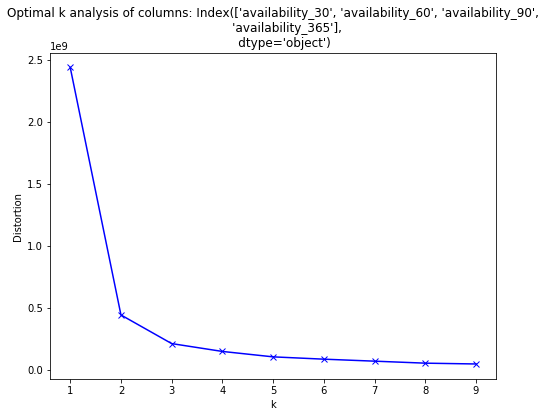

In [19]:
# Plotting kmeanModel elbow for selecting K
X = df[availability_columns]
display_elbow_of_selected_columns(X,  1, 10)


kmodel.labels_: [1 1 1 ... 2 2 2]
np.bincount(kmodel.labels_): [ 25410 103012  29442]


C:\Users\itzikjan\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


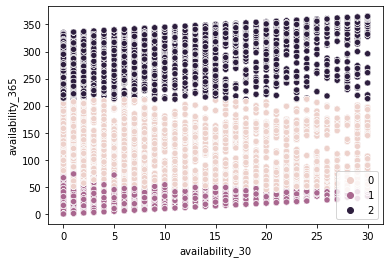

In [20]:
# Based on the above plot selecting n_clusters=3 
kmodel = KMeans(n_clusters=3, random_state=0).fit(X)
print("kmodel.labels_:", kmodel.labels_)
print("np.bincount(kmodel.labels_):", np.bincount(kmodel.labels_))
sns.scatterplot(df['availability_30'], df['availability_365'],hue= kmodel.labels_)

Based on the above it seems there are significant clusters sepration. 

In [21]:
df['kmean_cluster_availability']= kmodel.labels_
chi2_res = stats.chi2_contingency(pd.crosstab(df['kmean_cluster_availability'], df['booked_up_target']))
print("1a. pvalue of kmean_cluster_availability and booked_up_target is: ", chi2_res[1])   

pvalue of kmean_cluster_availability and booked_up_target is:  0.0


'kmean_cluster_availability' has pvalue < 0.05 --> keep it as feature. 

#### 1.b  Transformation of vars with subtraction and division

Checking the correlation between the variables (eda_numric_correlations.csv).
If the correlation between 2 variables is high (more than 0.8 or less than -0.8) creating new variables of division and subtraction.


In [22]:
df_eda_numric_correlations[np.abs(df_eda_numric_correlations['correlation_between_vars'])>=0.8]

,var1,var2,target,correlation_between_vars,pvalue_between_vars,correlation_var1_target,pvalue_var1_target,correlation_var2_target,pvalue_var2_target
0,target_avg_dollar_price_in_period,avg_dollar_price_in_previous_period,booked_up_target,0.982365,0.0,NaN,NaN,-0.120453,7.034347e-251
1,availability_60,availability_90,booked_up_target,0.957945,0.0,-0.497006,0.000000e+00,-0.559652,0.000000e+00
2,target_avg_dollar_price_in_period,price,booked_up_target,0.951098,0.0,NaN,NaN,-0.205355,0.000000e+00
3,weekly_price,monthly_price,booked_up_target,0.925822,0.0,-0.183143,3.604881e-193,-0.191507,3.043746e-153
4,avg_dollar_price_in_previous_period,price,booked_up_target,0.917291,0.0,-0.120453,7.034347e-251,-0.205355,0.000000e+00
5,availability_30,availability_60,booked_up_target,0.907023,0.0,-0.421644,0.000000e+00,-0.497006,0.000000e+00
6,calculated_host_listings_count,host_total_listings_count,booked_up_target,0.901281,0.0,-0.268586,0.000000e+00,-0.267512,0.000000e+00
7,availability_365,availability_90,booked_up_target,0.875757,0.0,-0.788367,0.000000e+00,-0.559652,0.000000e+00
8,availability_30,availability_90,booked_up_target,0.851459,0.0,-0.421644,0.000000e+00,-0.559652,0.000000e+00
9,price,weekly_price,booked_up_target,0.839673,0.0,-0.205355,0.000000e+00,-0.183143,3.604881e-193


In [24]:
# Adding subtraction and division variables of two variables with high correlation
# before dropping the variable with the lowest correlation with the target
def add_minus_and_div_to_numric_correlations_columns(_df:pd.DataFrame ,_df_numric_correlations: pd.DataFrame, correlation_between_vars_threshold: float = 0.8):
    """
    For each 2 numeric columns which have high corrleation between them, creating 2 new vars/fatures:
    1. var1-var2
    2. var1/var2
    """
    if correlation_between_vars_threshold:
        df_numric_correlations_filter_by_corr = _df_numric_correlations[np.abs(_df_numric_correlations['correlation_between_vars'])>=correlation_between_vars_threshold]
    else:
        df_numric_correlations_filter_by_corr = _df_numric_correlations
        
    for idx, row in df_numric_correlations_filter_by_corr.iterrows():
        var1 = row['var1']
        var2 = row['var2']
        minus_column_name = var1 + "_minus_" + var2
        div_column_name = var1 + "_div_" + var2
        _df[minus_column_name] = _df[var1] - _df[var2]
        _df[div_column_name] = _df[var1] / _df[var2]
    return _df

In [25]:
# transformation on each 2 columns (create minus and div for each couple of numeric columns)
df = add_minus_and_div_to_numric_correlations_columns(_df=df,_df_numric_correlations=df_eda_numric_correlations, correlation_between_vars_threshold=0.8 )
print("1b. transformation new colums:")
transform_col_list  = [col for col in df.columns if "_minus_" in col or "_div_" in col]
print("transformation new colums:", transform_col_list)

1. transformation new colums:
transformation new colums: ['target_avg_dollar_price_in_period_minus_avg_dollar_price_in_previous_period', 'target_avg_dollar_price_in_period_div_avg_dollar_price_in_previous_period', 'availability_60_minus_availability_90', 'availability_60_div_availability_90', 'target_avg_dollar_price_in_period_minus_price', 'target_avg_dollar_price_in_period_div_price', 'weekly_price_minus_monthly_price', 'weekly_price_div_monthly_price', 'avg_dollar_price_in_previous_period_minus_price', 'avg_dollar_price_in_previous_period_div_price', 'availability_30_minus_availability_60', 'availability_30_div_availability_60', 'calculated_host_listings_count_minus_host_total_listings_count', 'calculated_host_listings_count_div_host_total_listings_count', 'availability_365_minus_availability_90', 'availability_365_div_availability_90', 'availability_30_minus_availability_90', 'availability_30_div_availability_90', 'price_minus_weekly_price', 'price_div_weekly_price', 'availability_

#### 1.c  Get numric columns that can be dropped by high correlation

Checking the correlation between the variables (eda_numric_correlations.csv).
If the correlation between 2 variables is high (more than 0.8 or less than -0.8) check which variable has the highest and the lowest correlation with the target and keeping only the var that has highest correlation with the target.  
   

In [26]:
def get_numeric_cols_to_drop_by_correlation(_df_numric_correlations, correlation_between_vars_threshold = 0.8):
    """
    For each 2 numeric columns which have high corrleation between them (more then 80%), 
    check which variable has the highest and the lowest correlation with the target, 
    keep the var with highest correlation to the target and get a list of drop vars which has lowest correlation with target
    _df_numric_correlations has the following columns
    ['var1', 'var2', 'target', 'correlation_between_vars',
           'pvalue_between_vars', 'correlation_var1_target', 'pvalue_var1_target',
           'correlation_var2_target', 'pvalue_var2_target']
    """
    # get rows that 2 vars/features have high correlation between them. 
    df_numric_correlations_filter_by_corr = _df_numric_correlations[np.abs(_df_numric_correlations['correlation_between_vars'])>=correlation_between_vars_threshold]
    
    columns_to_drop = set()
    # for each row we drop the var that has low correlation with target column
    for idx, row in df_numric_correlations_filter_by_corr.iterrows():
        correlation_var1_target = row['correlation_var1_target']
        correlation_var2_target = row['correlation_var2_target']
        if correlation_var1_target and correlation_var2_target and np.abs(correlation_var1_target) > np.abs(correlation_var2_target):
            columns_to_drop.add(row['var2'])
        else:
            columns_to_drop.add(row['var1'])
    return columns_to_drop



In [27]:
# Get a list of numeric columns to drop (for each couple of vars drop the columns with lowest correlation to target)
numeric_cols_to_drop = get_numeric_cols_to_drop_by_correlation(df_eda_numric_correlations)
print("1c. dropping colums:", numeric_cols_to_drop)

df.drop(numeric_cols_to_drop, inplace=True, axis=1)

1c. dropping colums: {'target_num_of_day_in_period', 'host_total_listings_count', 'availability_30', 'weekly_price', 'avg_dollar_price_in_previous_period', 'reviews_per_month', 'availability_60', 'availability_90', 'occupancy_last_period', 'target_avg_dollar_price_in_period'}


### Explantion of the reuslts:
1. 'availability_30', 'availability_60', 'availability_90' and 'availability_365' have high correlation between each of them (correlatioin is more than  80%). The fucntion keeps only 'availability_365' var because this var has the highest correlation with the target. 
2. "target_avg_dollar_price_in_period", "avg_dollar_price_in_previous_period", "weekly_price" and "price" have high correlatioin between each of them but "price" has the highest correlation to target. 
Also, monthly_price is not dropped because it doesn't have correlation with price. 

In [ ]:
df.info(verbose=True, show_counts=True)

### 2. Categorical Columns Statistically Difference

I use the chi-squared test to determine whether there is a statistically significant difference between the two categories variables.

This test will help me to find new variables.
I am going to explore if there are combinations between the values of the categories variables that are statistically significant to the target "booked_up_target", and adding them as variables to the data.

In [ ]:
df_eda_pval_of_categorical_columns = pd.read_csv("eda_pval_of_categorical_columns.csv")
# This table has been taken from the EDA section, representing the categorical variables 
# that have statistically significant differences,  based on  Chi-squared Test (χ2 test).
df_eda_pval_of_categorical_columns = drop_additional_index_columns(df_eda_pval_of_categorical_columns)
df_eda_pval_of_categorical_columns

In [ ]:
def get_dummies_of_2_vars(_df, _col1, _col2, unique_values_limitation=7):
    """
    "create dummies" of 2 categorical colums -> create new column for each possibale metch of value. 
    """
    col1_unique_values = _df[_col1].unique()
    col2_unique_values = _df[_col2].unique()
    col1_unique_count = len(col1_unique_values)
    col2_unique_count = len(col2_unique_values)
    if unique_values_limitation != None:
        if  col1_unique_count > unique_values_limitation or col2_unique_count > unique_values_limitation:
            print(f' *** {_col1} has {col1_unique_count} unique values and {_col2} has {col2_unique_count} unique values - Not creating dummies ****')
            return _df
    print(_col1, "number of unique values: ", len(col1_unique_values))
    print(_col2, "number of unique values: ", len(col2_unique_values))
    added_columns = []
    def _is_dummy(_row_val_1,_unique_val1,_row_val_2 ,_unique_val2):
        if _row_val_1 == _unique_val1 and _row_val_2 == _unique_val2:
            return 1
        else:
            return 0
        
    for unique_val_1 in col1_unique_values:
        for unique_val_2 in col2_unique_values:
            
            print("_col1:", _col1 ,"unique_val_1: ", unique_val_1,"_col2:",_col2, "unique_val_2: ", unique_val_2)
            new_col = "_".join([_col1, unique_val_1, _col2, unique_val_2])
            added_columns.append(new_col)
            print("new_col:", new_col)
            _df[new_col] = _df.apply(lambda row:_is_dummy(row[_col1], unique_val_1, row[_col2], unique_val_2),axis=1)
    print("number of added columns", len(added_columns))
    return _df

###############################################################################################
#### Test
###############################################################################################
df_test = pd.DataFrame({"my_col_1":["a1", "a2", "a1","a1"], "my_col_2": ["b1", "b1", "b2", "b2"]})
df_actual_test = get_dummies_of_2_vars(df_test, 'my_col_1', "my_col_2")
display(df_actual_test)
df_expected_test = pd.DataFrame({"my_col_1":["a1", "a2", "a1","a1"], "my_col_2": ["b1", "b1", "b2", "b2"], 
                           "my_col_1_a1_my_col_2_b1": [1, 0 , 0 ,0],
                           "my_col_1_a1_my_col_2_b2": [0, 0, 1 , 1],
                           "my_col_1_a2_my_col_2_b1": [0, 1, 0, 0],
                           "my_col_1_a2_my_col_2_b2": [0, 0, 0, 0]})

pd.testing.assert_frame_equal(df_actual_test,df_expected_test)

In [ ]:
def get_dummies_of_2_vars_v2(_df, _col1, _col2,_target_col="booked_up_target", unique_values_limitation=5, pval_threshold_of_new_col_with_target=0.05):
    """
    "create dummies" of 2 categorical colums -> create new column for each possibale metch of value. 
    """
    col1_unique_values = _df[_col1].unique()
    col2_unique_values = _df[_col2].unique()
    col1_unique_count = len(col1_unique_values)
    col2_unique_count = len(col2_unique_values)
    added_columns = []
    if unique_values_limitation != None:
        if  col1_unique_count > unique_values_limitation or col2_unique_count > unique_values_limitation:
            print(f' *** {_col1} has {col1_unique_count} unique values and {_col2} has {col2_unique_count} unique values - Not creating dummies ****')
            return _df, []
    print(_col1, "number of unique values: ", len(col1_unique_values))
    print(_col2, "number of unique values: ", len(col2_unique_values))
    
    def _is_dummy(_row_val_1,_unique_val1,_row_val_2 ,_unique_val2):
        if _row_val_1 == _unique_val1 and _row_val_2 == _unique_val2:
            return 1
        else:
            return 0
        
    for unique_val_1 in col1_unique_values:
        for unique_val_2 in col2_unique_values:
            
            print("_col1:", _col1 ,"unique_val_1: ", unique_val_1,"_col2:",_col2, "unique_val_2: ", unique_val_2)
            new_col = "_".join([_col1, unique_val_1, _col2, unique_val_2])
            added_columns.append(new_col)
            print("new_col:", new_col)
            _df[new_col] = _df.apply(lambda row:_is_dummy(row[_col1], unique_val_1, row[_col2], unique_val_2),axis=1)
            chi2_res = stats.chi2_contingency(pd.crosstab(_df[new_col],_df[_target_col]))
            pval = chi2_res[1]
            if pval > pval_threshold_of_new_col_with_target:
                print(f"****chi2_contingency between {new_col} and {_target_col} have pval of {pval} (more than {pval_threshold_of_new_col_with_target})")
                print(f"***drop {new_col} ")
                _df.drop(new_col, inplace=True, axis=1)
            else:
                added_columns.append(new_col)
    print("number of added columns", len(added_columns))
    return _df, added_columns



In [ ]:
df_eda_pval_of_categorical_columns

In [ ]:
from datetime import datetime
total_columns = []
num_of_uniqiue_values = {}
for index, row in df_eda_pval_of_categorical_columns.iterrows():
    start_time = datetime.now()
    var1 = row['var1']
    var2 = row['var2']
    df[var1] = df[var1].astype('category')
    df[var2] = df[var2].astype('category')
    print("var1: ", var1)
    print("var2: ", var2)
    # _df, _col1, _col2,_target_col="booked_up_target", unique_values_limitation=5, pval_threshold_of_new_col_with_target=0.05
    df, added_columns = get_dummies_of_2_vars_v2(_df=df, _col1=var1, _col2=var2, _target_col="booked_up_target", unique_values_limitation=5, pval_threshold_of_new_col_with_target=0.05)
    total_columns + added_columns
    end_time = datetime.now()
    print("added_columns: ", added_columns)
    print(row['var1'], row['var2'], "total time: ", end_time-start_time)
print("total_columns added: ", total_columns)

In [ ]:
#Create column which indicates distance from center based on latitude and longitude variables.

#Get Berlin coordinates
#https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
#https://www.latlong.net/place/berlin-germany-9966.html

from geopy.distance import great_circle
def distance_from_berlin(lat, lon):
    berlin_centre = (52.50277, 13.404166)
    record = (lat, lon)
    return great_circle(berlin_centre, record).km

#add distanse dataset
df['distance'] = df.apply(lambda x: distance_from_berlin(x.latitude, x.longitude), axis=1)


df.head(1)

### Feature Transformation

In [ ]:
import itertools

def from_col_list_to_is_exists_columns(_df, col_of_list , ignore_values_list = ['a','']):
    # itreate on all rows and get all optional values in col_of_list
    # create list of unique values.
    # create df of col_of_list without None
    df_col = _df[pd.isna(_df[col_of_list]) == False ][col_of_list]
   
    merged = list(itertools.chain(*df_col.to_list())) 
    #display(df_col)
    # each row in df_col conatins list of strs, flat all list to single list
    flat_list = list(itertools.chain(*df_col.to_list())) 
    # print(flat_list)
    list_of_columns_to_add = list(set(flat_list)-set(ignore_values_list))
    # add column be each value of the list (equivalent for creating one hot encoding/dummies)
    
    for new_col in list_of_columns_to_add:
        is_exists = new_col in _df[col_of_list]
        
        _df[new_col] = _df[col_of_list].apply(lambda x: 1  if (x and new_col in x) else 0 )
    
    return _df
        
######################################################################
# Testing
######################################################################        
df_test = pd.DataFrame({'amenities_list': [["tv", "cable_tv"],["heating", "washer"]] } )
df_test = from_col_list_to_is_exists_columns(df_test, col_of_list = 'amenities_list')

df_expected = pd.DataFrame({'amenities_list': [["tv", "cable_tv"],["heating", "washer"]], "tv": [1,0], "cable_tv":[1,0], "heating":[0,1], "washer": [0,1] })
pd.testing.assert_frame_equal(df_test,df_expected[df_test.columns])


#### Transform "Amenities" column (set of attributes) column to Dummies columns
Amenities columns contains dict of attribute. Transform each attribute to feature.
From all attributes that appears in amenities, creating multiple features (equivalent to making dummies/One hot encoding).

In [ ]:
df['amenities'][1]

In [ ]:
def set_to_list(amenities_val):
    # amenities_val is set of words that is kept in str. Example '{TV,"Cable TV",Wifi,Kitchen,Gym, ... }')
    amenities_str = str(amenities_val)[1:-1].split(",") # ['TV', '"Cable TV"', 'Wifi', 'Kitchen', 'Gym']
    
    # remove "" from prases with spaces, replace spaces with _ and cast prases to lower
    return [s.strip('"').lstrip().lower().replace(" ", "_") for s in amenities_str]


# Test set_to_list method
df_test = pd.DataFrame({'amenities': ['{TV,"Cable TV",Wifi,Kitchen,Gym}', '{Heating,Washer,Essentials,Shampoo,"Hair dryer"}']} )
df_test['amenities_list'] = df_test['amenities'].apply(set_to_list)

df_expected = pd.DataFrame({'amenities': ['{TV,"Cable TV",Wifi,Kitchen,Gym}', '{Heating,Washer,Essentials,Shampoo,"Hair dryer"}'],
                           'amenities_list': [["tv", "cable_tv", "wifi", "kitchen", "gym"],["heating", "washer", "essentials", "shampoo", "hair_dryer"]] } )

pd.testing.assert_frame_equal(df_test,df_expected)



In [ ]:
df['amenities_list'] = df['amenities'].apply(set_to_list)

In [ ]:
df = from_col_list_to_is_exists_columns(df, col_of_list = 'amenities_list')

#### Transform "host_verifications" column (set of attributes) column to Dummies columns 
host_verifications columns contains list of attribute. Transform each attribute to feature.
From all attributes that appears in host_verifications, creating multiple features (equivalent to making dummies/One hot encoding).

In [ ]:
df['host_verifications'][1]

In [ ]:
import ast
# host_verifications conatins list that transformed to str (repersented as string)
# ast.literal_eval can be use to transform back to list (from the str of list)
ast.literal_eval(df['host_verifications'][1])

In [ ]:
# host_verifications_list is the represntaion of host_verifications as list (intead of str)
df['host_verifications_list'] = df['host_verifications'].apply(ast.literal_eval)

In [ ]:
df = from_col_list_to_is_exists_columns(df, col_of_list = 'host_verifications_list')

#### Transform categorical variables - dummy encoding
add dummies encoding for categorical features

In [ ]:
#  Defining the categorical variables:
category_cols = ['neighbourhood_group','room_type', 'property_type'
'host_response_time','host_is_superhost','host_has_profile_pic',
'host_identity_verified', 'bed_type', 'instant_bookable','is_business_travel_ready','require_guest_profile_picture',
 'require_guest_phone_verification','cancellation_policy', 'concat_comments_sentiment']
# add the numeric categories that transfored to categories colums
category_cols += [x for x in df.columns.to_list() if x.endswith("cat")]

print(category_cols)

In [ ]:
df_with_dummies = pd.get_dummies(df, columns=category_cols)

In [ ]:
dummies_coulmns = list(set(df_with_dummies.columns)-set(df.columns))
print(f"get_dummies method add {len(dummies_coulmns)} columns. The new columns are: ")
dummies_coulmns

In [ ]:
# Representing the dimensionality of the DataFrame (after Feature Enrichment):
df_with_dummies.shape

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
for col in df_with_dummies.columns:
    print(col)

In [ ]:
selected_vars = [listing_id, target_start_date_period, target_end_date_period , start_date_previous_period
,end_date_previous_period, square_feet, monthly_price, concat_comments_sentiment,target_num_of_booked_days,
booked_up_target, num_of_day_in_previous_period , num_of_booked_days_in_previous_period, price,
minimum_nights, number_of_reviews, DaysPassed_last_review, calculated_host_listings_count, availability_365,
DaysPassed_host_since
accommodates
bathrooms
bedrooms
beds
security_deposit
cleaning_fee
guests_included
extra_people
maximum_nights




       
                 
                 
                 
                 
                 
                 
                 
neighbourhood_group
neighbourhood
latitude
longitude
room_type



In [ ]:
df['accommodates']

### Feature Selection

Selection based on voting: using many of the techniques (univariate and multivariate), we make
a table with all the variables on the dataset and indicate the recommended variables for each
technique, then we select a threshold for the total votings and on this basis we select the variables
that will be used to train our models.